[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ThomasAlbin/TBD)

# TBD

In [1]:
# Import standard libraries
import os

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import sklearn
from sklearn import preprocessing
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow.keras as keras

In [7]:
# Let's mount the Google Drive, where we store files and models (if applicable, otherwise work
# locally)
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""
    
# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())

In [8]:
# We need to encode our string-based labels to either a sparse representation (class C becomes 0,
# S becomes 1, etc.) or to One-Hot-Encoding (e.g., C becomes [1, 0, 0, 0], S becomes [0, 1, 0, 0]
# and so on.

# Please note: a better way to create models that can be used in production, encoding shall be
# stored e.g., in a json file. Otherwise one needs to store the encoding class (otherwise the
# encoding - decoding information is gone!!!)
label_encoder = preprocessing.OneHotEncoder(sparse=True)
asteroids_oh_y = label_encoder.fit_transform(asteroids_y.reshape(-1,1)).toarray()

# OK how are things encoded?
oh_init = [1, 0, 0, 0]
for n in range(4):
    oh_class = oh_init[-n:] + oh_init[:-n]
    org_class = label_encoder.inverse_transform([oh_class])
    print(f"One-Hot-Vector {oh_class} corresponds to the Main Group: {org_class[0][0]}")
    
# In this example we create a single test-training split with a ratio of 0.8 / 0.2
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_oh_y[train_index], asteroids_oh_y[test_index]

One-Hot-Vector [1, 0, 0, 0] corresponds to the Main Group: C
One-Hot-Vector [0, 1, 0, 0] corresponds to the Main Group: Other
One-Hot-Vector [0, 0, 1, 0] corresponds to the Main Group: S
One-Hot-Vector [0, 0, 0, 1] corresponds to the Main Group: X


In [9]:
X_train

array([[0.9218, 0.9316, 0.9413, ..., 1.0263, 1.0272, 1.03  ],
       [0.9262, 0.9326, 0.9388, ..., 0.9791, 0.9769, 0.9745],
       [0.7862, 0.8063, 0.8268, ..., 1.1329, 1.1367, 1.1422],
       ...,
       [0.7833, 0.8046, 0.8258, ..., 1.0932, 1.0851, 1.0772],
       [0.9607, 0.965 , 0.9693, ..., 1.0017, 1.0003, 0.9994],
       [0.767 , 0.7925, 0.8176, ..., 1.1022, 1.1057, 1.11  ]])

In [10]:
# Import the preprocessing module
from sklearn import preprocessing

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
scaler = preprocessing.StandardScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)

# Scale the testing data ...
X_test_scaled = scaler.transform(X_test)

In [11]:
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

## Building the Autoencoder

Now we create a ConvNet Autoencoder. Since we have a rather small dataset we

In [25]:
import tensorflow.keras as keras

# Get the number of inputs
n_inputs = asteroids_X.shape[1]

# Let's create an autoencoder
n_bottleneck = 2

def create_model():
    
    input_layer = keras.Input(shape=(n_inputs, 1))
    
    hidden_layer = keras.layers.Conv1D(filters=32,
                                       activation="relu",
                                       kernel_size=3, padding="same")(input_layer)
    #hidden_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_layer)
    
    hidden_layer = keras.layers.Conv1D(filters=64,
                                       activation="relu",
                                       kernel_size=3, padding="same")(hidden_layer)
    #hidden_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_layer)
    
    # Encoder ("Bottleneck" of the Autoencoder)
    bottleneck_lay = keras.layers.Flatten()(hidden_layer)
    bottleneck_lay = keras.layers.Dense(n_bottleneck)(bottleneck_lay)


    # The original shape must be restored and reshaped accordingly
    reset_lay = keras.layers.Dense(3136)(bottleneck_lay)
    reshape_lay = keras.layers.Reshape((49,64))(reset_lay)

    # First and second hidden decoder layers
    hidden_layer = keras.layers.Conv1DTranspose(64, 3, strides=1,
                                                activation="relu", padding="same")(reshape_lay)
    hidden_layer = keras.layers.Conv1DTranspose(32, 3, strides=1,
                                                activation="relu", padding="same")(hidden_layer)

    # Ouput layer (same size as input layer)
    output_layer = keras.layers.Conv1D(1, 1, padding="same")(hidden_layer)

    # Create model
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model, bottleneck_lay

model, _ = create_model()

# Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
model.compile(optimizer='adam', loss='mse')

# Show the model summary
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 49, 1)]           0         
                                                                 
 conv1d_16 (Conv1D)          (None, 49, 32)            128       
                                                                 
 conv1d_17 (Conv1D)          (None, 49, 64)            6208      
                                                                 
 flatten_6 (Flatten)         (None, 3136)              0         
                                                                 
 dense_12 (Dense)            (None, 2)                 6274      
                                                                 
 dense_13 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_4 (Reshape)         (None, 49, 64)            0   

In [26]:
# Train the model
end_epoch = 100
batch_size = 32

# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_scaled, X_train_scaled,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=1,
                    validation_split=0.25)

Epoch 1/100
26/26 [==============================] - 1s 10ms/step - loss: 0.6518 - val_loss: 0.2191
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 0.2073 - val_loss: 0.1354
Epoch 3/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0933 - val_loss: 0.0484
Epoch 4/100
26/26 [==============================] - 0s 6ms/step - loss: 0.0391 - val_loss: 0.0310
Epoch 5/100
26/26 [==============================] - 0s 6ms/step - loss: 0.0312 - val_loss: 0.0293
Epoch 6/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0300 - val_loss: 0.0286
Epoch 7/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0290 - val_loss: 0.0284
Epoch 8/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0287 - val_loss: 0.0276
Epoch 9/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0285 - val_loss: 0.0278
Epoch 10/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0286 - val_loss: 0.0291
Epoch 11

## The loss function

Let's show the loss of the training and test data. As you can see, the minimum-plateau is reached quite fast. The test data performs slightly better than the training data, since the loss results for the training data are based on an average of the batch size. The test results are based on all data.

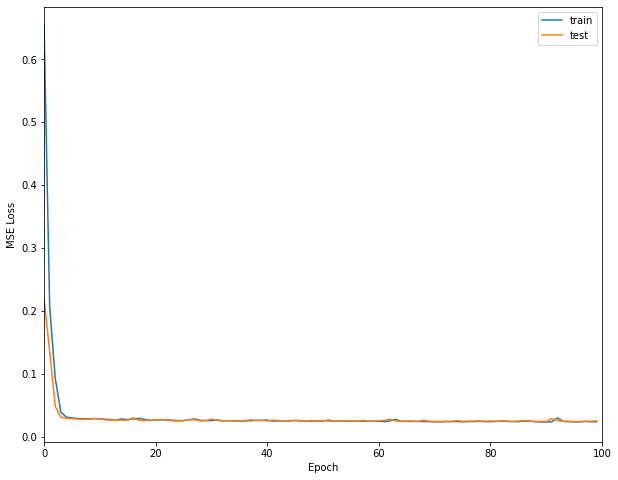

In [27]:
# plot the training and validation loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

# Add legend and labels
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

# Limit the x axis
plt.xlim(0, end_epoch)

# ... aaaaand plot!
plt.show()

## Signal Reconstruction

... can be done by using the entire model to predict the output spectra. The following code snippet takes a signal (change the index value in the first line to use any other signal) and predicts the Autoencoder based spectrum.

As one can see, the results are "quite ok" but far from perfect. The shape of the spectra can be reproduced. However, the signals are quite noisy. The question is now: Do we have a low-dimensional clustering?

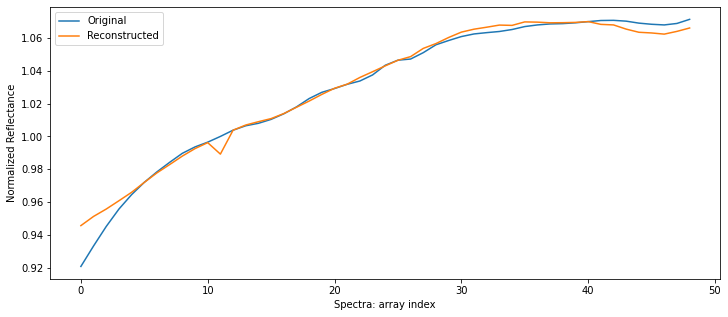

In [39]:
# Which index shall be displayed?
index_val = 100

# plot the training and reconstructed data
plt.figure(figsize=(12,5))
plt.plot(scaler.inverse_transform(X_train_scaled[index_val].reshape(1,-1))[0], label='Original')
plt.plot(scaler.inverse_transform(model.predict(X_train_scaled)[index_val].reshape(1,-1))[0], label='Reconstructed')

# Add legend and labels
plt.legend()
plt.xlabel("Spectra: array index")
plt.ylabel("Normalized Reflectance")

# ... aaaaand plot!
plt.show()